In [1]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, colors

## Colors

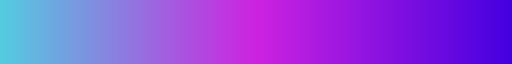

In [2]:
colors_lst, red, cmap = colors.color_scheme()
cmap

## Prelims

In [53]:
## Parameters

Nin = 2
Nout = 2

## task type
task_type='Regression'

# extra nodes
extraNin: int = 0
Ninter: int = 0
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.])

stay_sample: int = 2

# length of training dataset
iterations = int(2e4)  # number of sampled of p

stay_sample = 2

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 
    
window_for_mean = 1000
    
alpha: float = 0.2  # for network combine attempt

## funcs

In [54]:
def network_build_given_Nin_Nout(Nin: int, Nout: int, M_norm: NDArray[np.float_]) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(dataset_size,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    Variabs.create_dataset_and_targets(rand_state, M_norm[:])
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def train_loop(Variabs, Strctr, State, BigClass):
    loss_mean = [1, 1]
    for l in range(iterations):
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            State.calc_loss(BigClass)
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
        if not (l+1)%window_for_mean:
            # print('l', l)
            loss_mean.append(np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1)))
            # print(loss_mean)
            
        if loss_mean[-1]<10e-10 or (loss_mean[-1]-loss_mean[-2])>0 or loss_mean[-1]>2:
            break
            
    return State

## M

In [55]:
rand_state=array([42])

M_values = matrix_functions.random_gen_M(rand_state[0], Nout*Nin)
M = M_values[0:Nout*Nin].reshape(Nout, Nin)
M_line = np.sum(M, axis=1)
M_norm = M[:Nin*Nout]/np.max(M_line)*0.75  # normalize so max sum over line will be 0.75

print('M_norm')
print(M_norm)

M_norm
[[0.21110328 0.53585423]
 [0.41257615 0.33742385]]


## X

In [56]:
X_values = matrix_functions.random_gen_M(rand_state, Nin*Nin)  # take random samples of pressure
X = X_values.reshape(Nin, Nin)

X[-2,:] = X[-1,:]  # last sample is the same as one before, overdetermined set of equations
# X[-3,:] = X[-1,:]
# X[-4,:] = X[-1,:]
# X[-5,:] = X[-1,:]

dataset_size = np.shape(X)[0]-1  # change num of samples accordingly

In [57]:
X

array([[0.73199394, 0.59865848],
       [0.73199394, 0.59865848]])

## Desired

In [58]:
Y = np.matmul(X,M_norm.T)  # sized NoutxNin

print(Y)

[[0.47532    0.50400489]
 [0.47532    0.50400489]]


## Pseudo inv

finding M from inputs X and deisred outputs Y where the last two lines of X are the same, so overdetermined set of equations

In [59]:
M_pinv = np.matmul(np.linalg.pinv(X),Y).T

print('M pseudo inv')
print(M_pinv)

M pseudo inv
[[0.38909483 0.31821974]
 [0.41257615 0.33742385]]


## Network solution

In [60]:
# solve the network
Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_norm.ravel())
State = train_loop(Variabs, Strctr, State, BigClass)

R_vec_i has wrong size, initializing all ones


In [61]:
# extract solved M using only a single input of 1 at every time
M_networksol = zeros([Nout, Nin])
for i in range(Nin):
    State.input_drawn = zeros(Nin)
    State.input_drawn[i] = 1
    State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)
    M_networksol[:,i] = State.output

In [65]:
State.R_in_t[0]

array([1., 1., 1., 1., 1., 1., 1., 1.])

Text(0.5, 0, '$t$')

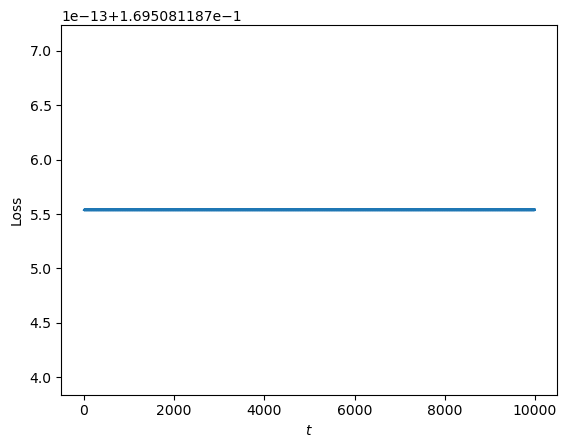

In [63]:
plt.plot(np.mean(np.mean(np.abs(State.loss_norm_in_t), axis=1), axis=1))
plt.ylabel('Loss')
plt.xlabel(r'$t$')

In [64]:
print('M (norm)')
print(M_norm)

print('M pseudo inv')
print(M_pinv)

print('M network solution')
print(M_networksol)

M (norm)
[[0.21110328 0.53585423]
 [0.41257615 0.33742385]]
M pseudo inv
[[0.38909483 0.31821974]
 [0.41257615 0.33742385]]
M network solution
[[0.33333333 0.33333333]
 [0.33333333 0.33333333]]
